# Tratamento de Dados de Tomografia por Técnicas de Álgebra Linear Computacional

*Emanuel Piveta Pozzobon, Henrique Valente Nogueira, Pedro Coelho Gimenes de Freitas e Rafael Dalacorte Erdmann*

*Ilum - Escola de Ciência, 2024*

Este caderno cumpre duas funções: explica como utilizar a biblioteca ```Tomopy``` para reconstruir imagens tomográficas a partir de dados reais, extraídos do repositório ```TomoBank``` e explica nossa implementação do algoritmo de Técnicas de Reconstrução Algébrica (TRA, também conhecido como método de Kaczmarz) conforme descrito por Anton & Rorrers (2012).

## Tomopy

Biblioteca de Python especializada em tomografias computadorizadas, o ```Tomopy``` oferece diversas ferramentas de reconstrução e correção de imagens. Para fazê-lo funcionar no seu sistema, deve-se ter ```Conda``` instalado e seguir informações disponíveis na [página de direções de instalação](https://tomopy.readthedocs.io/en/stable/install.html). Além dele, será necessária a instalação da biblioteca [```DXchange```](https://dxchange.readthedocs.io/en/latest/source/install.html), responsável pela leitura e importação dos arquivos de dados tomográficos (outros requisitos são ```Olefile``` e ```AstroPy```).

Aqui exibiremos resultados de duas bases de dados: [Lorentz](https://tomobank.readthedocs.io/en/latest/source/data/docs.data.lorentz.html) e [Nano CT Ângulos Esparsos](https://tomobank.readthedocs.io/en/latest/source/data/docs.data.nano.html). Ambas estão disponíveis no repositório [```TomoBank```](https://tomobank.readthedocs.io/en/latest/index.html).

Para análise e exibição dos dados, foram utilizadas ferramentas das bibliotecas ```NumPy```, ```SciPy``` e ```MatPlotLib```. A construção de alguns códigos foi auxiliada pelo ChatGPT 4.0 (licença gratuita de uso diário limitado), com exceção da biblioteca ```Tomopy```, na qual o modelo encontra dificuldade em trabalhar.

### Base de dados: Lorentz

Começamos importando as bibliotecas necessárias.

In [8]:
import tomopy
import dxchange
import matplotlib.pyplot as plt
import logging
import numpy as np
from scipy.ndimage import zoom
from scipy.ndimage import rotate

logging.basicConfig(level=logging.INFO)

O próximo passo é importar os dados. Aqui, usaremos apenas a fatia 540, exatamente no centro das 1080 fatias dos dados. 

In [9]:
proj, flat, dark, theta = dxchange.read_aps_32id(
    fname='tomo_00088.h5', # nome do arquivo
    sino=(539,540) # lembrando que como o Python conta índices a partir do zero, o sinograma 539 é o 540
)

INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00088.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00088.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00088.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00088.h5


A seguir, realizamos tratamentos breves dos dados: se o vetor de ângulos tiver sido definido pelo arquivo do dataset, a função ```angles()``` pode ser usada para montá-la; realiza-se a normalização dos dados de acordo com matrizes de calibração, transformação dos valores para escala logarítmica com ```minus_log()``` e eliminação de dados faltantes.

In [10]:
# cálculo dos ângulos, se necessário
if theta is None:
    theta = tomopy.angles(proj.shape[0])

# normalização
proj = tomopy.normalize(proj, flat, dark)

# escala logaritmica
proj = tomopy.minus_log(proj)

# elimina dados faltantes (NaN)
proj = np.nan_to_num(proj, nan=0.0, posinf=0.0, neginf=0.0)

Agora já podemos plotar nossos dados no formato de sinograma

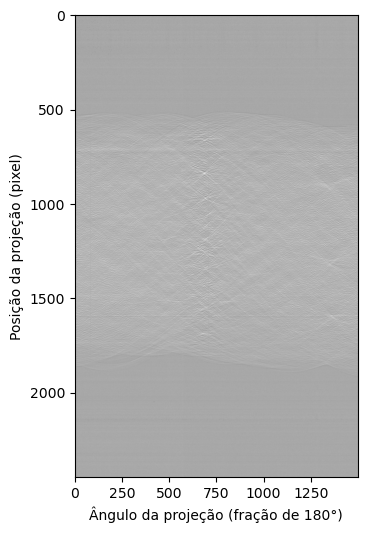

In [11]:
# sinograma
plt.figure(figsize=(6,6))
plt.imshow(proj[:, 0, :].T, cmap="gray")
plt.xlabel("Ângulo da projeção (fração de 180°)")
plt.ylabel("Posição da projeção (pixel)")
plt.show()

Nesse momento, definimos o centro de rotação dos nossos dados. Isso está disponível na documentação do dataset, nesse caso é 1226,0. Mas caso não se saiba o centro de rotação, é possível utilizar uma das duas funções abaixo para calcular o centro de rotação com uma boa aproximação.

In [12]:
rot_center = 1226.0

# cálculo de centro de rotação
#rot_center = tomopy.find_center_vo(proj)
#rot_center = tomopy.find_center(proj, theta, ind=proj.shape[1]//2)

Com essas informações, pode-se realizar a reconstrução da imagem. Aqui pode-se alterar o algoritmo utilizado pela biblioteca, dentre as opções: 'art', 'bart', 'fbp', 'gridrec', 'mlem', 'osem', 'ospml_hybrid', 'ospml_quad', 'pml_hybrid', 'pml_quad', 'sirt', 'tv', 'grad', 'tikh'. Utilizaremos gridrec.

In [13]:
recon = tomopy.recon(proj, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


Exibimos, então, o resultado da imagem reconstruída:

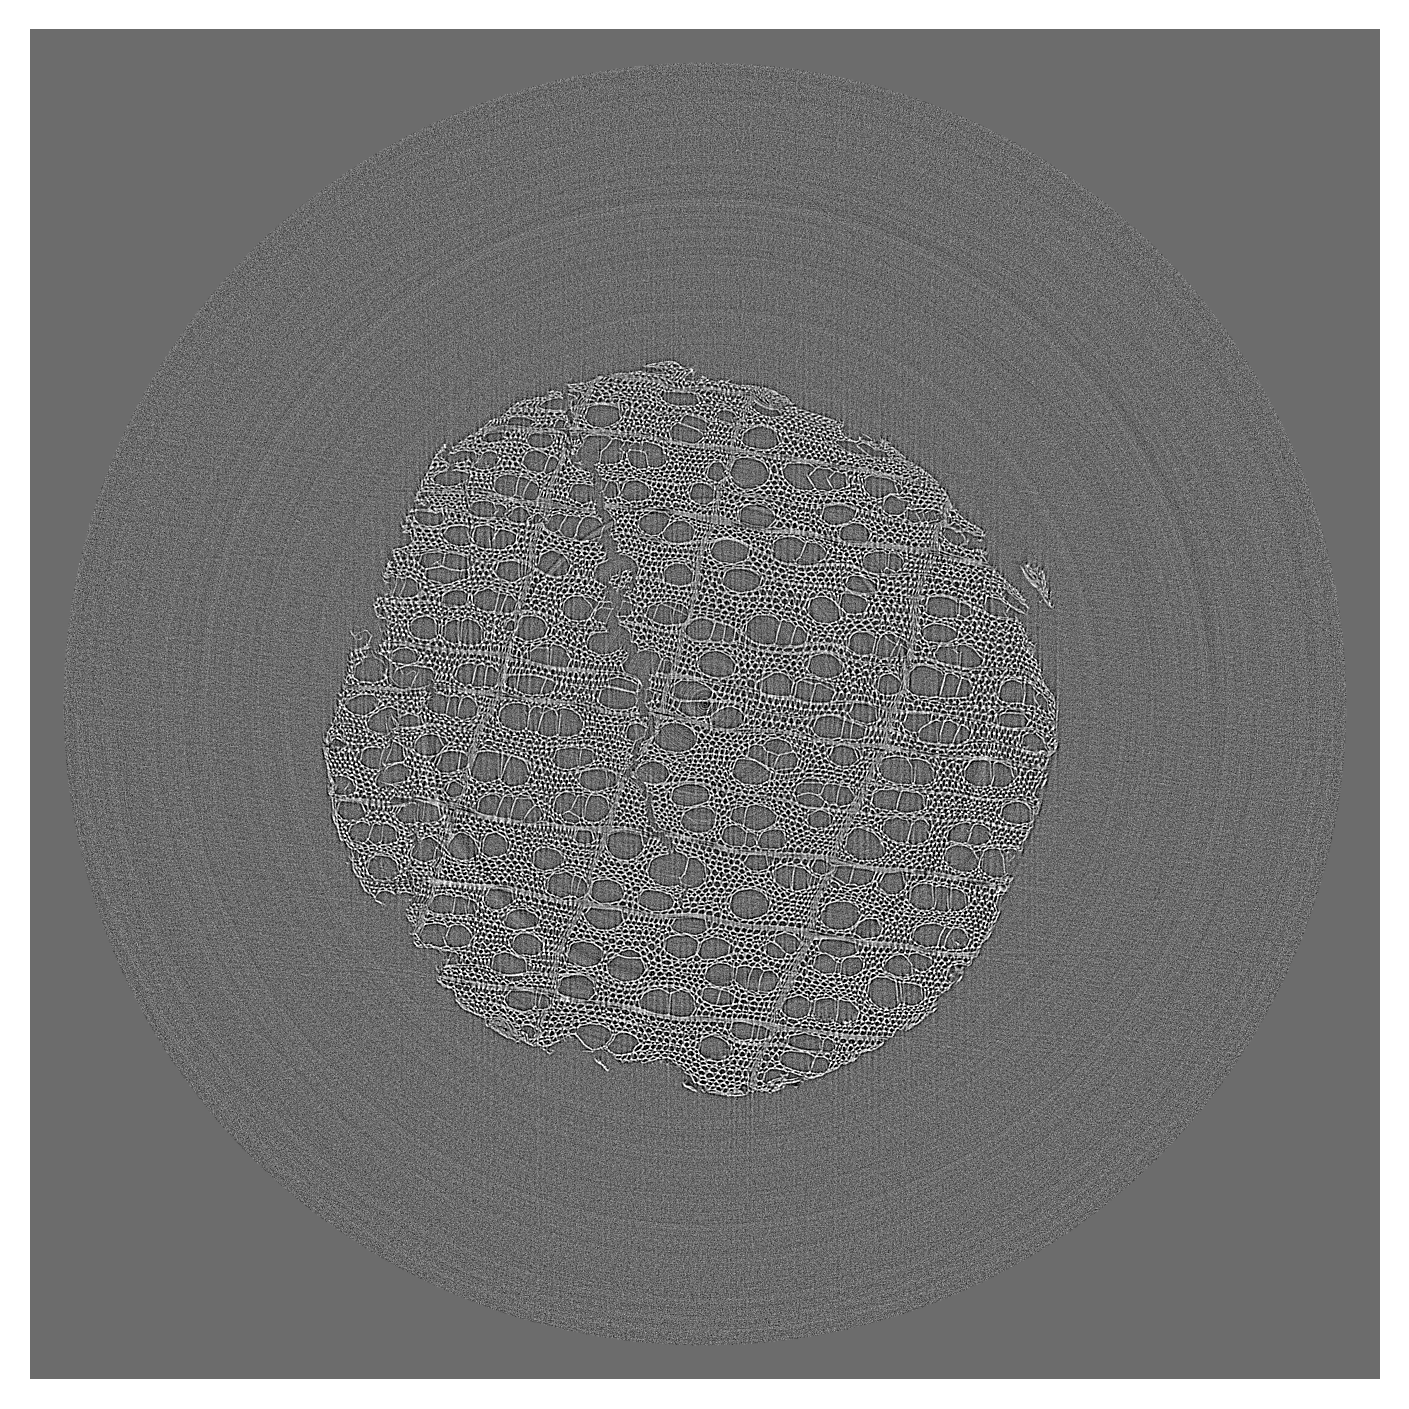

In [14]:
plt.figure(dpi=300)
plt.imshow(recon[0, :, :], cmap='gray', vmin=-0.0011, vmax=0.0015)
plt.axis("off")
plt.tight_layout()

plt.show()

Para vias de comparação com o resultado do nosso algoritmo de TRA, utilizamos o código abaixo para reduzir a dimensionalidade da imagem produzida para 49x49 (tamanho limite obtido pelo método).

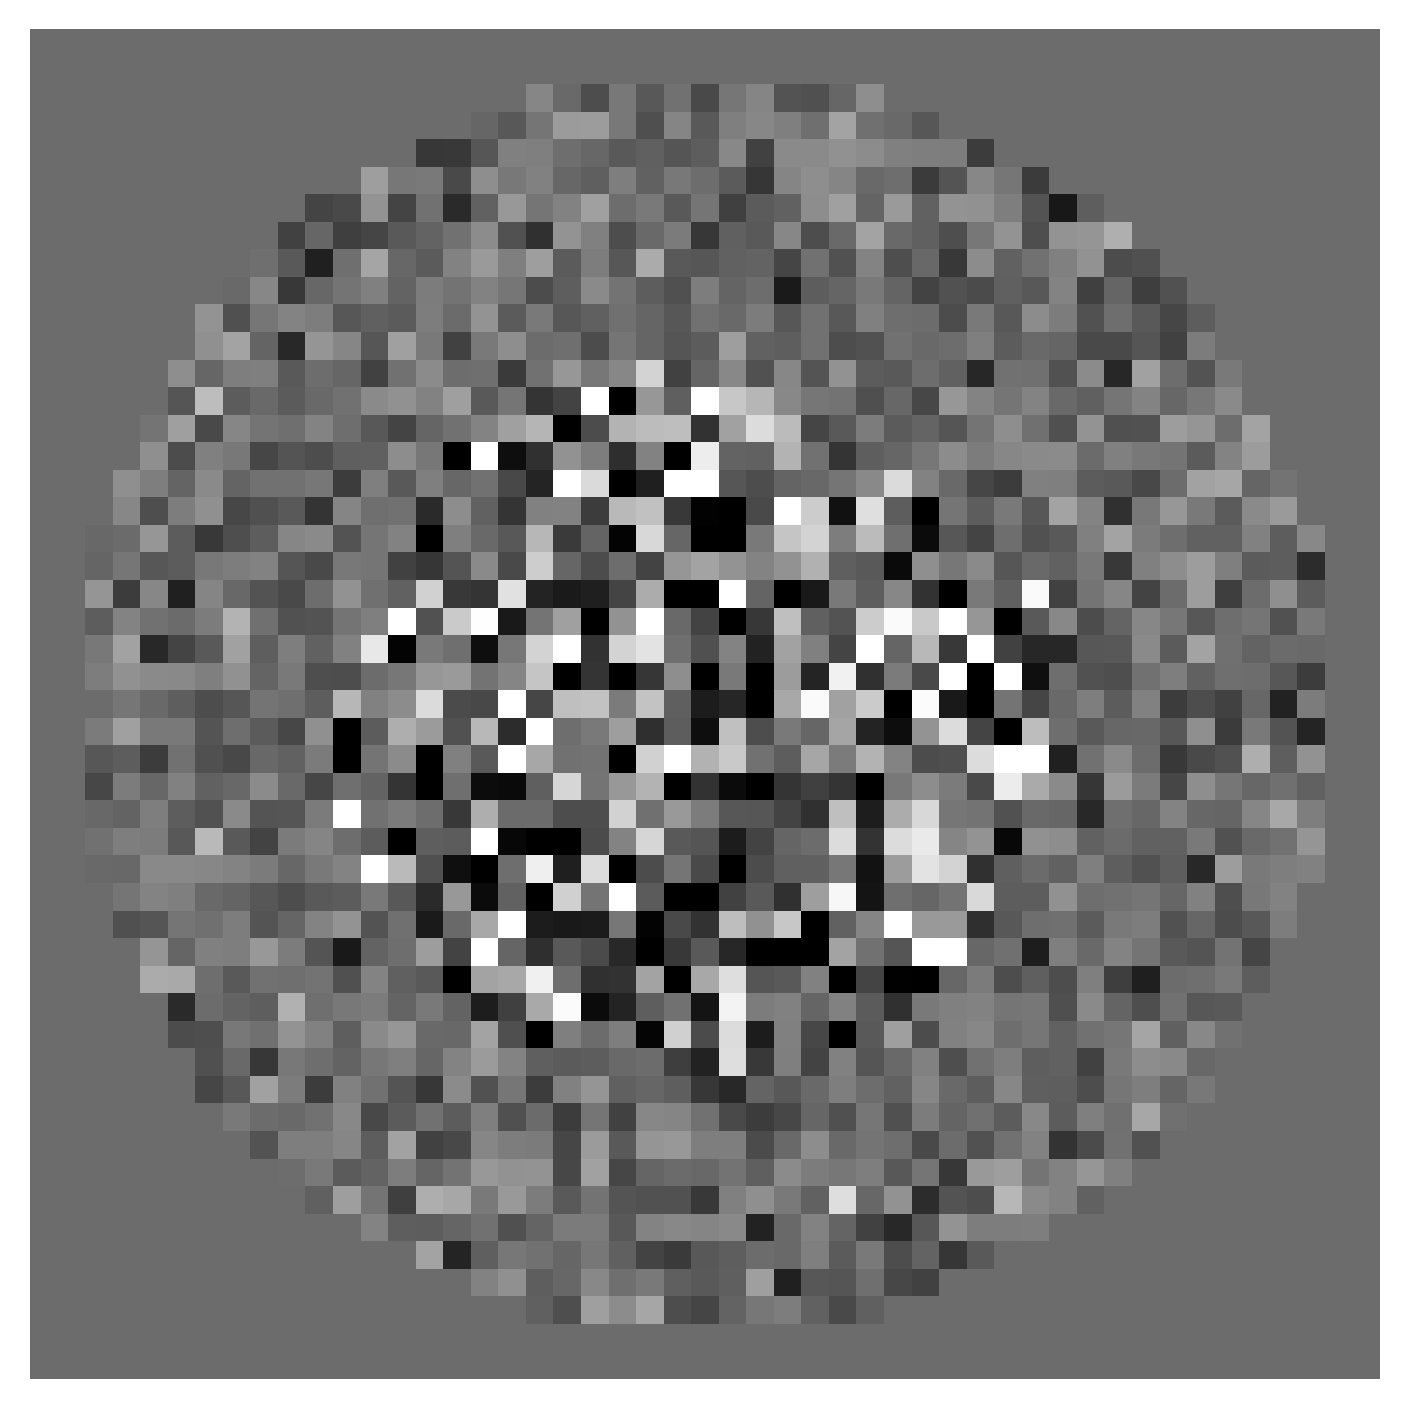

In [15]:
# redução de dimensionalidade
# fator de redução (por exemplo, 0.5 reduz pela metade)
fator = 49/2448
# reduz a resolução das reconstruções (imagem, largura, altura)
recon = zoom(recon, (1, fator, fator), order=1)

plt.figure(dpi=300)
plt.imshow(recon[0,:,:], cmap='gray', vmin=-0.0011, vmax=0.0015)
plt.axis("off")
plt.tight_layout()

plt.show()

### Base de dados: ângulos esparsos

Para a segunda base de dados, o processo é igual ao descrito anteriormente.

INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00086.h5


INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00086.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00086.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00086.h5


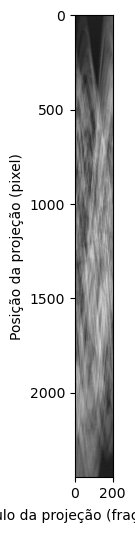

In [16]:
proj, flat, dark, theta = dxchange.read_aps_32id(
    fname='tomo_00086.h5',
    sino=(539,540)
)

rot_center = 1227.0

if theta is None:
    theta = tomopy.angles(proj.shape[0])

proj = tomopy.normalize(proj, flat, dark)

proj = tomopy.minus_log(proj)

# elimina dados NaN
proj = np.nan_to_num(proj, nan=0.0, posinf=0.0, neginf=0.0)

# sinograma
plt.figure(figsize=(10,6))
plt.imshow(proj[:, 0, :].T, cmap="gray")
plt.xlabel("Ângulo da projeção (fração de 180°)")
plt.ylabel("Posição da projeção (pixel)")
plt.show()

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


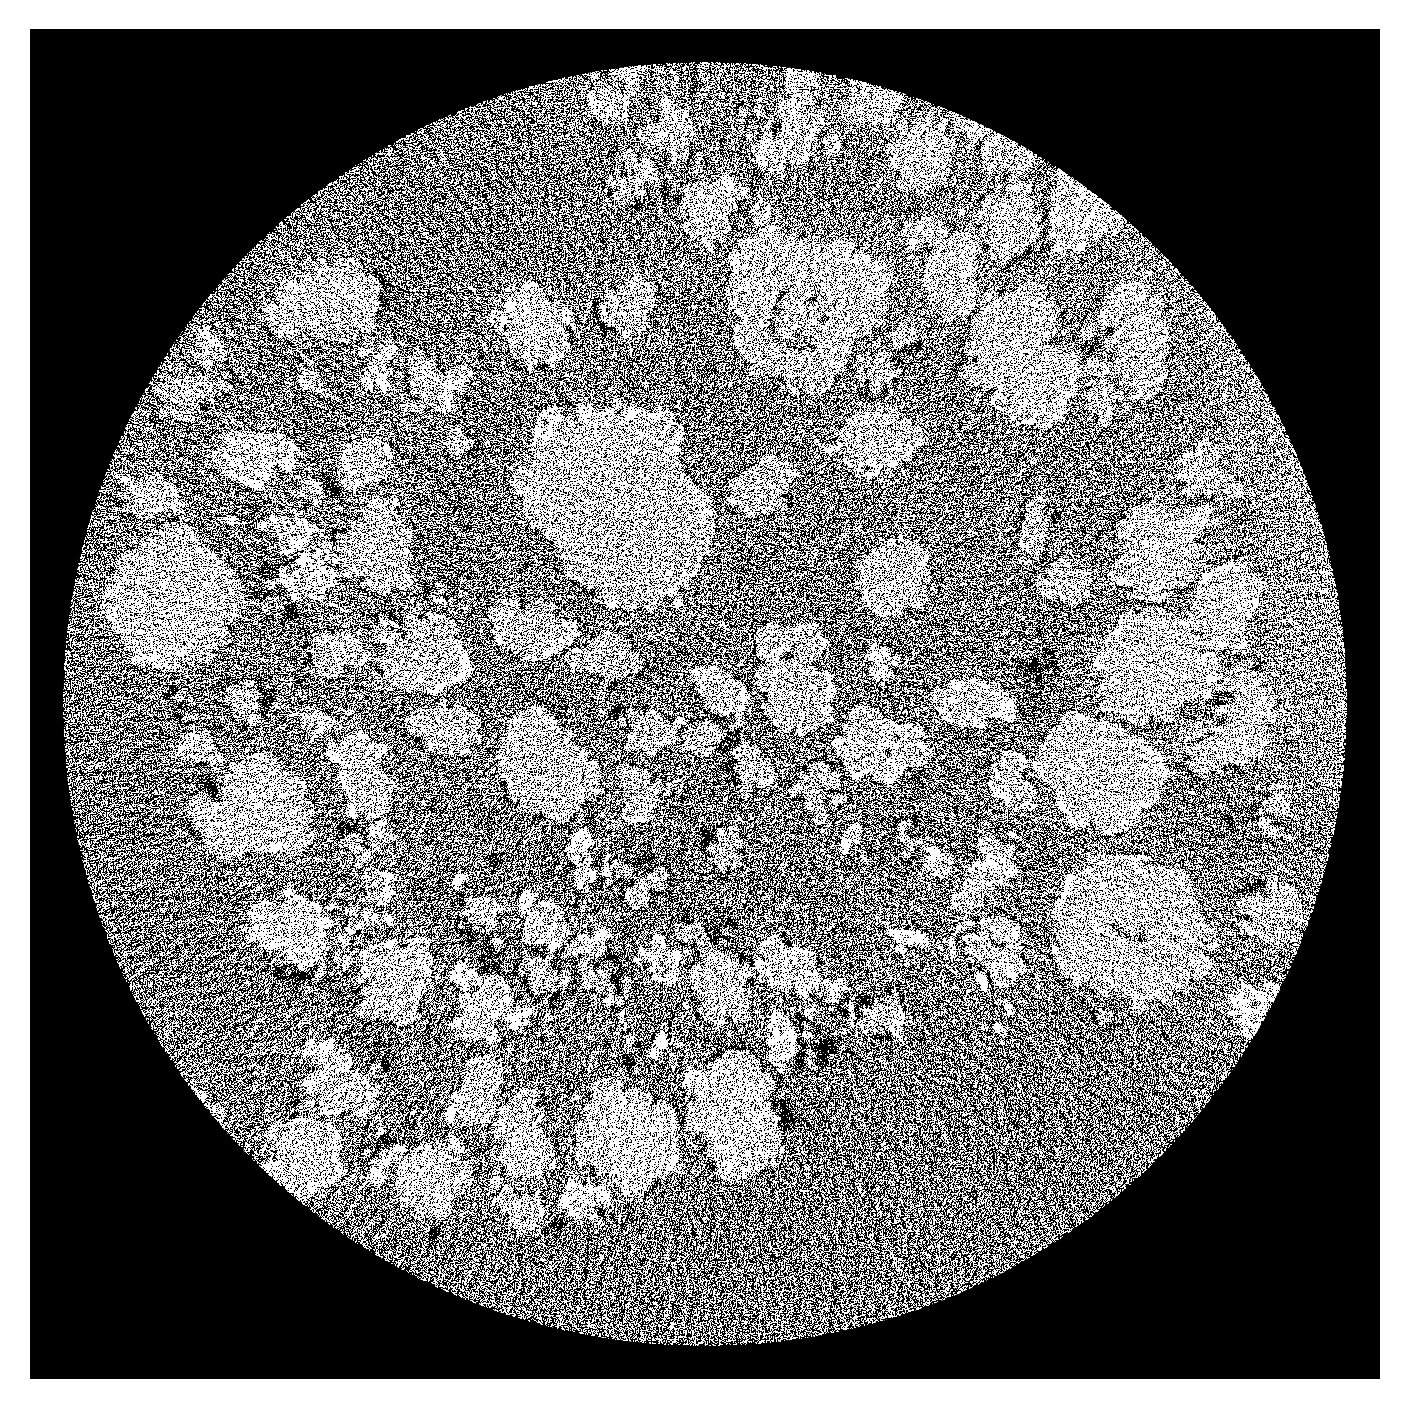

In [17]:
recon = tomopy.recon(proj, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

plt.figure(dpi=300)
plt.imshow(recon[0, :, :], cmap='gray', vmin=0.000, vmax=0.0001)
plt.axis("off")
plt.tight_layout()

plt.show()

Novamente, reduzimos a dimensionalidade para comparação com o algoritmo de TRA.

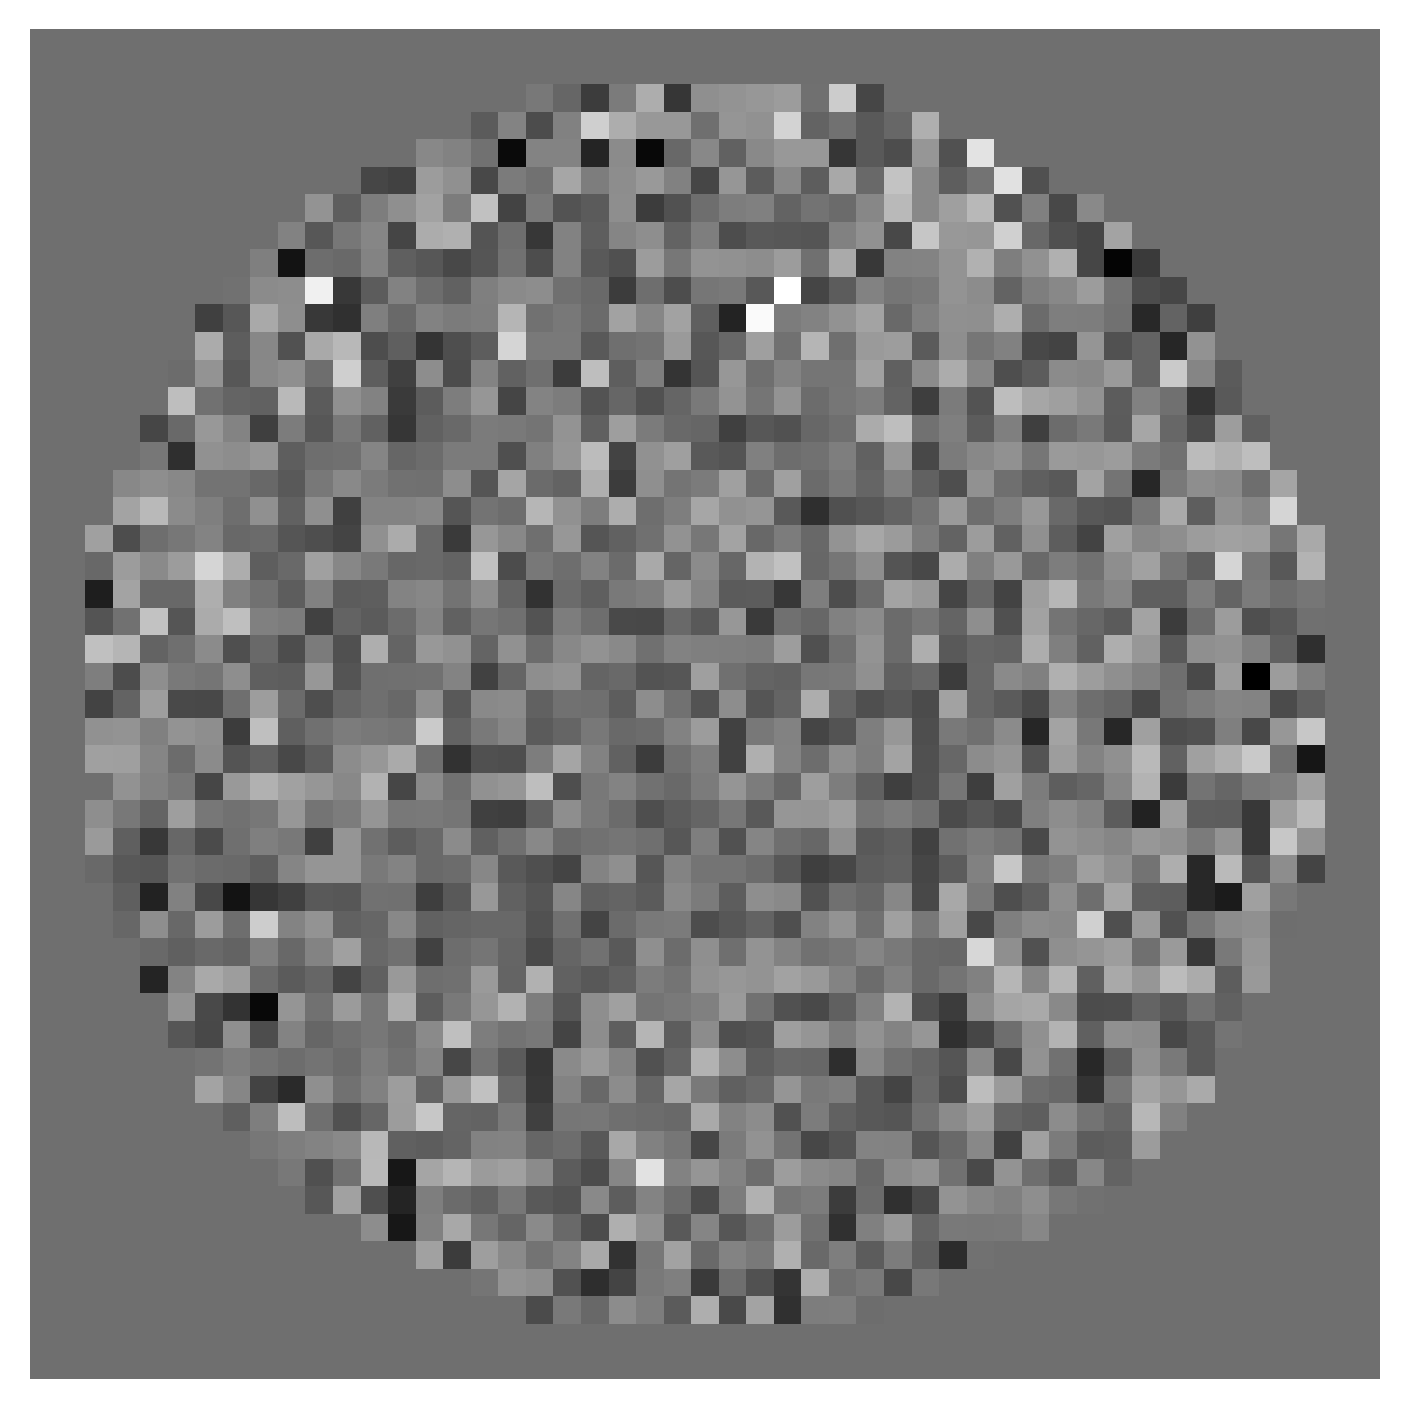

In [18]:
# redução de dimensionalidade
fator = 49/2448
recon = zoom(recon, (1, fator, fator), order=1)

plt.figure(dpi=300)
plt.imshow(recon[0, :, :], cmap='gray')
plt.axis("off")
plt.tight_layout()

plt.show()

## Técnica de Reconstrução Algébrica (TRA)

### Base de dados: Lorentz

Para a reconstrução de uma imagem bidimensional com a TRA, precisaremos de dados de pixels em número quadrado perfeito, pois nosso resultado final será uma matriz quadrada, com centro de rotação. Com este propósito, aplicaremos a mesma redução de dimensionalidade das imagens passadas, mas diretamente nos dados para conseguir 2401 pixels (49x49).

In [19]:
proj, flat, dark, theta = dxchange.read_aps_32id(
    fname='tomo_00088.h5',
    sino=(539,540)
)

if theta is None:
    theta = tomopy.angles(proj.shape[0])

proj = tomopy.normalize(proj, flat, dark)
proj = tomopy.minus_log(proj)
proj = np.nan_to_num(proj, nan=0.0, posinf=0.0, neginf=0.0)

# redução de dimensionalidade
fator = 2401/2448
# reduz a resolução das projeções (projeções, sinograma, pixels)
proj = zoom(proj, (1, 1, fator), order=1)  # 'order=1' é a interpolação linear

INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00088.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00088.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00088.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00088.h5


A célula abaixo define as funções que realizam os cálculos conforme descritos no relatório escrito.

In [20]:
def proj_orto(a, b, x):
    # para a e x como np.arrays com dimensão n, sendo a uma linha de uma matriz A_{mxn}
    # b é um valor pertencente a um vetor com dimensão m
    if a.T @ a > np.finfo(float).eps:
        xp = x + a * (b-a.T @ x)/(a.T @ a)
    else: # caminho para evitar a.T @ a muito próximo de zero
        xp = x + a * (b-a.T @ x)/(1e-15)
    return xp

def projecoes (A, b, x, i): 
    resultados = []

    for _ in range(i-1): 
        
        for k in range(A.shape[0]):
            x = proj_orto(A[k], b[k], x)

    for k in range(A.shape[0]):
                x = proj_orto(A[k], b[k], x)
                resultados.append(x)
    return resultados

A = np.array(
    proj[:,0,:]
)

b = np.array(theta)

x = np.ones(A.shape[1])

imagens = projecoes (A, b, x, 10)

A função abaixo encerra o processo somando cada projeção com sua devida rotação de ângulo (definido pelo passo do detector dos dados).

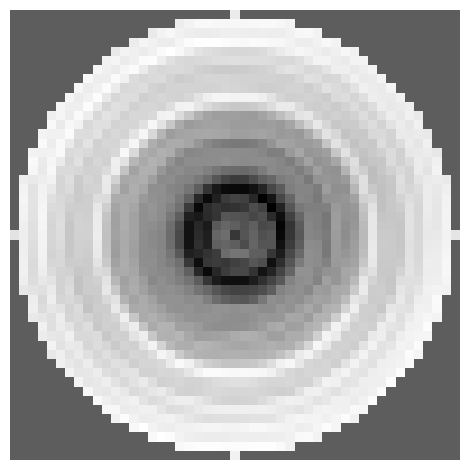

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
def imagem_TRA(proj, angulos, vinheta=True):
    # sendo proj uma lista de imagens projetadas por TRA e angulos a np.array de ângulos dos dados
    imagem = proj[0].copy().reshape((int(np.sqrt(proj[0].shape[0])), -1))

    for i in range(1, len(proj)):

        # cria uma matriz representando uma imagem
        projecao_nova = proj[i].copy().reshape((int(np.sqrt(proj[i].shape[0]))), -1)

        # especifica o ângulo de rotação e o centro
        angulo = angulos[i]*180  # deve ser em graus, caso a array angulos já esteja, o *180 deve ser apagado

        # realiza a rotação da imagem
        projecao_rotacionada = rotate(projecao_nova, angle=angulo, reshape=False, order=1, mode='constant', cval=0.0)
        imagem += projecao_rotacionada

    if vinheta:
        # dimensões da imagem
        altura, largura = imagem.shape
        centro = (altura // 2, largura // 2)  # centro da imagem

        raio = largura // 2 
        x = np.arange(altura)
        y = np.arange(largura)
        X, Y = np.meshgrid(x, y)
        distancia = np.sqrt((X - centro[0]) ** 2 + (Y - centro[1]) ** 2)

        # máscara binária: 1 dentro do raio, 0 fora
        vinheta = (distancia <= raio).astype(float)
    
        plt.imshow(imagem*vinheta, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        return imagem*vinheta
    
    else:
        plt.imshow(imagem, cmap="gray")
        plt.show()
        return imagem

imagem_TRA(imagens, theta, vinheta=True)


Discussões do resultado obtido estão disponíveis no relatório escrito.

### Base de dados: ângulos esparsos

Novamente, apenas repete-se o procedimento.

In [22]:
proj, flat, dark, theta = dxchange.read_aps_32id(
    fname='tomo_00086.h5',
    sino=(539,540)
)

if theta is None:
    theta = tomopy.angles(proj.shape[0])

proj = tomopy.normalize(proj, flat, dark)
proj = tomopy.minus_log(proj)

# elimina dados NaN
proj = np.nan_to_num(proj, nan=0.0, posinf=0.0, neginf=0.0)

# reduz dimensionalidade
# fator de redução (por exemplo, 0.5 para reduzir pela metade)
fator = 2401/2448

# reduzir a resolução das projeções (projeções, sinograma, pixels)
proj_downsampled = zoom(proj, (1, 1, fator), order=1)  # 'order=1' é a interpolação linear
proj = proj_downsampled

INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00086.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00086.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00086.h5
INFO:dxchange.reader:Data successfully imported: c:\Users\rafael24017\OneDrive - ILUM ESCOLA DE CIÊNCIA\Documentos\Portfolio Python\Algebra Linear Computacional\Trabalho Final\tomo_00086.h5


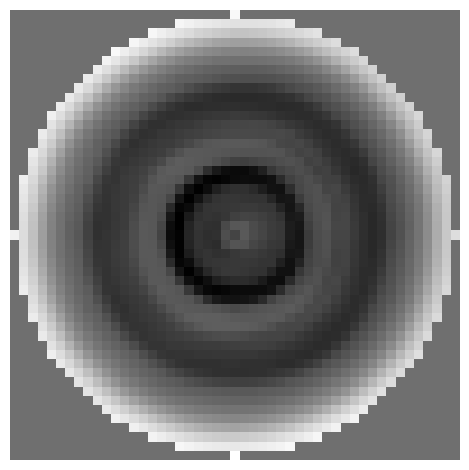

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
A = np.array(
    proj[:,0,:]
)

b = np.array(theta)

x = np.ones(A.shape[1])

imagens = projecoes (A, b, x, 10)
imagem_TRA(imagens, theta, vinheta=True)


Discussões do resultado obtido estão disponíveis no relatório escrito.

## Referências:

- ANTON, H., RORRERS, C, 2012. Álgebra linear com aplicações. Tradução técnica de DOERING, C. I. 10° edição. Porto Alegre: Bookman.

- Tomobank. Argonne National Laboratory, c2019. Disponível em: https://tomobank.readthedocs.io/en/latest/index.html

- Tomopy. Argonne National Laboratory, c2019. Disponível em: https://tomopy.readthedocs.io/en/stable/index.html

- DXchange. Argonne National Laboratory, c2016. Disponível em: https://dxchange.readthedocs.io/en/latest/index.html

- NumPy. NumPy Developers, c2024. Disponível em: https://numpy.org/doc/stable/

- SciPy. The SciPy community, c2024. Disponível em: https://docs.scipy.org/doc/scipy/

- Matplotlib. The Matplotlib development team, c2024. Disponível em: https://matplotlib.org/stable/api/index.html

- ChatGPT. OpenAI, c2024. Disponível em: https://chatgpt.com/